In [73]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

# Tensorboard

In [2]:
# tensorboard magic
# %load_ext tensorboard
# %tensorboard --logdir=./tensorboard-logs/image-classifier-fashion-dataset --port=6006

# setup directory and save files
import os
root_logdir = os.path.join(os.curdir, "./tensorboard-logs/image-classifier-fashion-dataset")
def get_run_logdir(): 
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

# Import Data

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Original Model

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
# model.add(keras.layers.InputLayer(input_shape=[28,28])) # this didnt work... )model.compile() threw an error
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

2022-08-17 10:16:01.287241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
weights = model.get_weights() # save initialized weights of model for model re-training

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers

In [11]:
weights, biases = model.layers[1].get_weights()

In [12]:
weights

array([[-0.0097084 ,  0.04076343,  0.02309974, ...,  0.05142699,
         0.02201376, -0.00136086],
       [-0.05688957,  0.04925981, -0.06647436, ..., -0.03517424,
         0.03730207,  0.07014781],
       [ 0.02919273,  0.0290492 ,  0.04646901, ..., -0.03354217,
         0.03247487,  0.0312112 ],
       ...,
       [ 0.05154483,  0.03987654,  0.04935957, ...,  0.05218419,
        -0.03516735, -0.02365451],
       [-0.05916353, -0.06649609, -0.00744744, ...,  0.03963844,
         0.04868799,  0.04242042],
       [ 0.0394746 ,  0.06087579,  0.02959251, ..., -0.01501825,
         0.01237451,  0.06441545]], dtype=float32)

In [13]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [14]:
# use bias initializer or kernel initializer

In [15]:
print(y_valid) # target is represented as sparse labels

[9 0 0 ... 5 8 3]


In [14]:
model.compile(loss="sparse_categorical_crossentropy", # sparse labels
              optimizer="sgd",
              metrics=["accuracy"])

From Keras Documentation https://keras.io/api/losses/probabilistic_losses/

*Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss. There should be # classes floating point values per feature for y_pred and a single floating point value per feature for y_true.*

From Hands-On Machine Learning, O'Reilly

*If we were doing binary
classification (with one or more binary labels), then we would use the "sigmoid" (i.e.,
logistic) activation function in the output layer instead of the "softmax" activation
function, and we would use the "binary_crossentropy" loss.*

*If the training set was very skewed, with some classes being overrepresented and others
underrepresented, it would be useful to set the class_weight argument when
calling the fit() method, which would give a larger weight to underrepresented
classes and a lower weight to overrepresented classes...*

*Per-instance weights could be useful if some instances were labeled
by experts while others were labeled using a crowdsourcing platform: you might want
to give more weight to the former.*

In [15]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    validation_data=(X_valid, y_valid),
#                    validation_split=0.1, # could use this instead
#                     class_weight=weights, # for setting the weight of each class (for instance, in an imbalanced data set)
                   )

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7257 - accuracy: 0.7609 - val_loss: 0.5349 - val_accuracy: 0.8134
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4938 - accuracy: 0.8263 - val_loss: 0.4755 - val_accuracy: 0.8292
Epoch 3/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4487 - accuracy: 0.8434 - val_loss: 0.4303 - val_accuracy: 0.8530
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4206 - accuracy: 0.8525 - val_loss: 0.4026 - val_accuracy: 0.8630
Epoch 5/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4011 - accuracy: 0.8594 - val_loss: 0.4098 - val_accuracy: 0.8540
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3840 - accuracy: 0.8655 - val_loss: 0.4032 - val_accuracy: 0.8570
Epoch 7/30
1123/1719 [==================>...........] - ETA: 1s - loss: 0.3693 - accuracy: 0.8697

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

*You can tell that the model has not
quite converged yet, as the validation loss is still going down, so you should probably
continue training. It’s as simple as calling the fit() method again, since Keras just
continues training where it left off (you should be able to reach close to 89% validation
accuracy).*

In [109]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 94.2362 - accuracy: 0.8532


[94.23624420166016, 0.8532000184059143]

*If you are not satisfied with the performance of your model, you should go back and
tune the hyperparameters. The first one to check is the learning rate. If that doesn’t
help, try another optimizer (and always retune the learning rate after changing any
hyperparameter). If the performance is still not great, then try tuning model hyperparameters
such as the number of layers, the number of neurons per layer, and the
types of activation functions to use for each hidden layer. You can also try tuning
other hyperparameters, such as the batch size (it can be set in the fit() method using
the batch_size argument, which defaults to 32).*

In [29]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 62ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [80]:
y_pred = model.predict(X_new)
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
print(np.array(class_names)[y_pred])

1/1 [==============================] - 0s 0s/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
['Ankle boot' 'Pullover' 'Trouser']


1/1 [==============================] - 0s 16ms/step


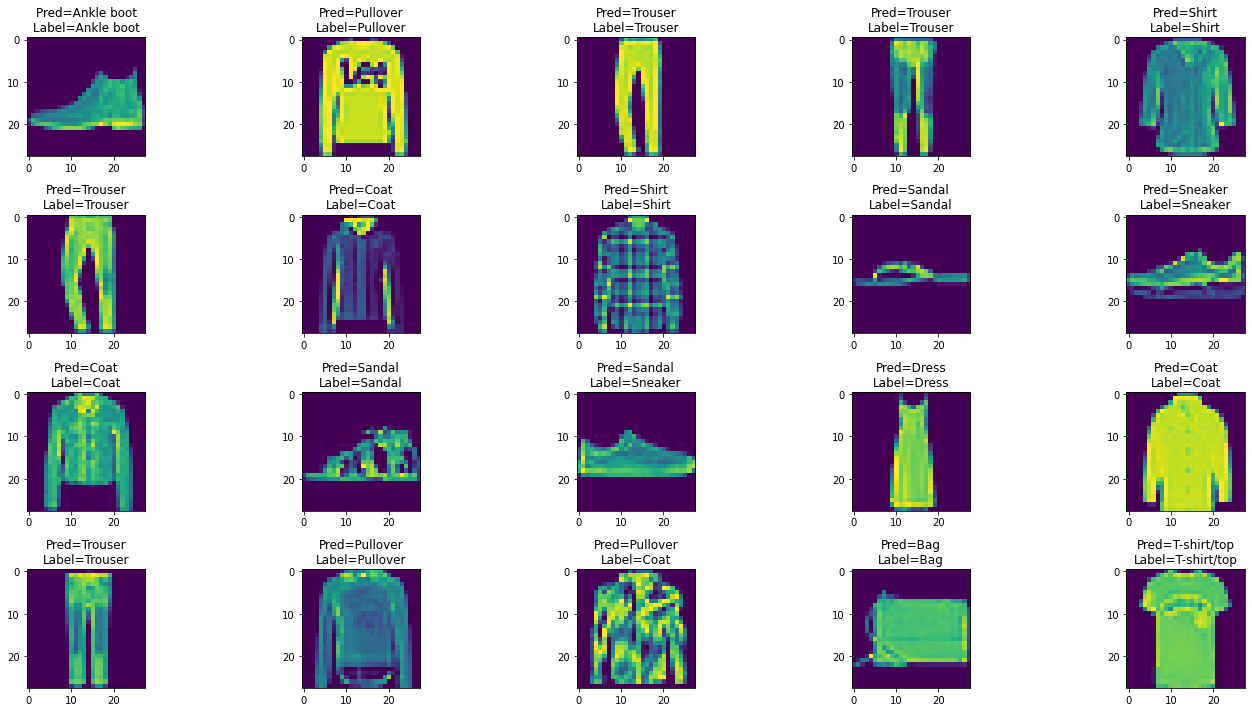

In [104]:
n = 20
fig, ax = plt.subplots(int(np.ceil(n/5)), 5, figsize=(n,n/2))

y_pred = model.predict(X_test[:n]) # create predictions for n samples
y_pred = np.argmax(y_pred, axis=1) # get the index of the prediction, across each row (sample)
pred_names = np.array(class_names)[y_pred] # get the class names of the predictions
label_names = np.array(class_names)[y_test[:n]] # get the class names of the true labels

for i in range(n):
    ind = np.unravel_index(i, ax.shape)
    ax[ind].imshow(X_test[i], interpolation='nearest')
    ax[ind].set_title('Pred=' + pred_names[i] + '\n' + 'Label=' + label_names[i])
plt.tight_layout()
plt.show()

## Original Model

In [74]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/original'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [75]:
# setup model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [76]:
# setup optimizer
optimizer = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [78]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
#     callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4238 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8442
Epoch 2/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3667 - accuracy: 0.8647 - val_loss: 0.4439 - val_accuracy: 0.8382
Epoch 3/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3343 - accuracy: 0.8748 - val_loss: 0.4231 - val_accuracy: 0.8326
Epoch 4/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3114 - accuracy: 0.8835 - val_loss: 0.3357 - val_accuracy: 0.8784
Epoch 5/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2946 - accuracy: 0.8901 - val_loss: 0.3360 - val_accuracy: 0.8734
Epoch 6/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2812 - accuracy: 0.8947 - val_loss: 0.3171 - val_accuracy: 0.8798
Epoch 7/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2680 - accuracy: 0.8992 - val_loss: 0.3184 - val_accuracy:

# Early Stopping

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [44]:
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer="sgd",
    metrics=["accuracy"]
)

In [45]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=30, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0726 - accuracy: 0.9718 - val_loss: 0.4868 - val_accuracy: 0.9024
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0690 - accuracy: 0.9729 - val_loss: 0.4931 - val_accuracy: 0.9050
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0678 - accuracy: 0.9734 - val_loss: 0.4963 - val_accuracy: 0.9044
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0671 - accuracy: 0.9730 - val_loss: 0.5022 - val_accuracy: 0.9026
Epoch 5/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0664 - accuracy: 0.9742 - val_loss: 0.5065 - val_accuracy: 0.9034
Epoch 6/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0658 - accuracy: 0.9745 - val_loss: 0.5091 - val_accuracy: 0.9036
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0653 - accuracy: 0.9746 - val_loss: 0.5088 - val_accuracy:

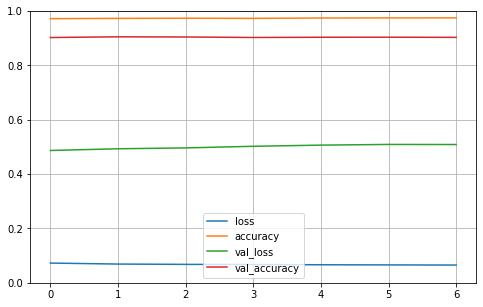

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Define own learning rate schedule

In [10]:
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
sgd = keras.optimizers.SGD(learning_rate=learning_rate, decay=decay_rate, nesterov=False)

In [11]:
# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

In [12]:
# fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=5, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3740 - accuracy: 0.8627 - val_loss: 0.3490 - val_accuracy: 0.8762
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3364 - accuracy: 0.8768 - val_loss: 0.3364 - val_accuracy: 0.8796
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3249 - accuracy: 0.8813 - val_loss: 0.3319 - val_accuracy: 0.8802
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3180 - accuracy: 0.8844 - val_loss: 0.3333 - val_accuracy: 0.8822
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3134 - accuracy: 0.8859 - val_loss: 0.3271 - val_accuracy: 0.8820


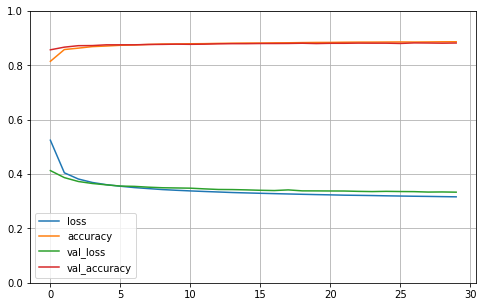

In [22]:
# plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Use learning rate scheduler

In [24]:
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0)

In [25]:
# setup LR scheduler
epochs = 50
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [26]:
# setup optimizer
sgd = keras.optimizers.SGD()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

# fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1967 - accuracy: 0.9255 - val_loss: 0.3116 - val_accuracy: 0.8896 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1889 - accuracy: 0.9272 - val_loss: 0.3213 - val_accuracy: 0.8898 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1848 - accuracy: 0.9303 - val_loss: 0.3353 - val_accuracy: 0.8854 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1802 - accuracy: 0.9304 - val_loss: 0.3678 - val_accuracy: 0.8842 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

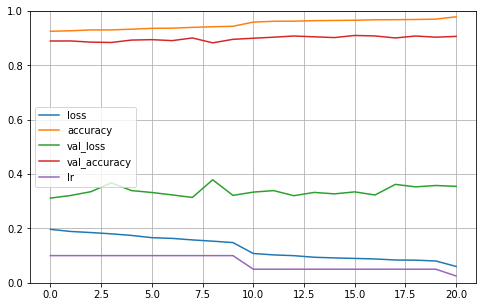

In [27]:
# plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Learning Rate Scheduler + Momentum

In [35]:
# early stopping
patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)

In [39]:
# setup callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [40]:
# setup LR scheduler
epochs = 50

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [41]:
# setup optimizer
sgd = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

# fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2757 - accuracy: 0.8990 - val_loss: 0.3619 - val_accuracy: 0.8848 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2710 - accuracy: 0.9008 - val_loss: 0.3681 - val_accuracy: 0.8802 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2682 - accuracy: 0.9027 - val_loss: 0.3551 - val_accuracy: 0.8816 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2537 - accuracy: 0.9073 - val_loss: 0.3808 - val_accuracy: 0.8858 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

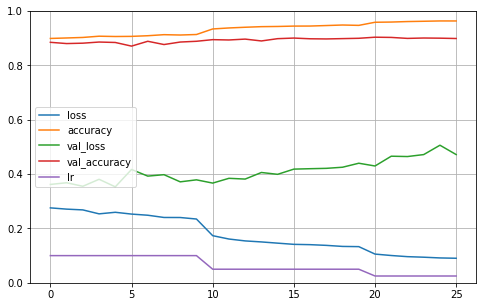

In [42]:
# plot
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Create a more complex model

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [57]:
# early stopping
patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)

In [58]:
# setup callback
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/3-layers'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [59]:
# setup LR scheduler
epochs = 50

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [60]:
# setup optimizer
sgd = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

# fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5503 - accuracy: 0.8043 - val_loss: 0.4008 - val_accuracy: 0.8506 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3923 - accuracy: 0.8566 - val_loss: 0.3623 - val_accuracy: 0.8648 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3487 - accuracy: 0.8724 - val_loss: 0.3316 - val_accuracy: 0.8762 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3237 - accuracy: 0.8807 - val_loss: 0.3162 - val_accuracy: 0.8850 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to

1719/1719 [==============================] - 6s 4ms/step - loss: 0.0796 - accuracy: 0.9735 - val_loss: 0.3178 - val_accuracy: 0.9012 - lr: 0.0012

Epoch 36: LearningRateScheduler setting learning rate to 0.0012499999720603228.
Epoch 36/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0780 - accuracy: 0.9736 - val_loss: 0.3253 - val_accuracy: 0.9050 - lr: 0.0012

Epoch 37: LearningRateScheduler setting learning rate to 0.0012499999720603228.
Epoch 37/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0763 - accuracy: 0.9744 - val_loss: 0.3221 - val_accuracy: 0.9032 - lr: 0.0012

Epoch 38: LearningRateScheduler setting learning rate to 0.0012499999720603228.
Epoch 38/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0743 - accuracy: 0.9747 - val_loss: 0.3348 - val_accuracy: 0.9026 - lr: 0.0012

Epoch 39: LearningRateScheduler setting learning rate to 0.0012499999720603228.
Epoch 39/50
1719/1719 [==============================] -

## Create a less complex model

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [62]:
# early stopping
patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=0.001)

# setup callback
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/2-layers'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# setup LR scheduler
epochs = 30

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

# setup optimizer
sgd = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

# fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5763 - accuracy: 0.7977 - val_loss: 0.4480 - val_accuracy: 0.8422 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4119 - accuracy: 0.8512 - val_loss: 0.3726 - val_accuracy: 0.8714 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3722 - accuracy: 0.8644 - val_loss: 0.3630 - val_accuracy: 0.8718 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3465 - accuracy: 0.8724 - val_loss: 0.3645 - val_accuracy: 0.8674 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to

# Hyper-parameter optimization

In [65]:
def create_model(hp):
    # setup hyperparameter space
    layers = hp.Choice('layers', [1,2,3])
    units = hp.Choice('units', np.arange(1, 100).tolist())

    # create model
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
    for layer in range(layers):
        model.add(keras.layers.Dense(units, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

    # setup optimizer
    sgd = keras.optimizers.SGD(momentum=0.8)

    # compile
    model.compile(
        loss="sparse_categorical_crossentropy", # sparse labels
        optimizer=sgd,
        metrics=["accuracy"]
    )

    return model

In [69]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

https://www.tensorflow.org/tutorials/keras/keras_tuner
*Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.*

In [71]:
history = tuner.search(X_train, y_train, 
                       validation_data=[X_valid, y_valid], 
                       epochs=25)

Trial 30 Complete [00h 00m 38s]
val_accuracy: 0.8894000053405762

Best val_accuracy So Far: 0.8894000053405762
Total elapsed time: 00h 08m 45s
INFO:tensorflow:Oracle triggered exit


In [74]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of layers is {best_hps.get('layers')}. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

In [76]:
model = tuner.hyp`ermodel.build(best_hps)

In [79]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 60)                47100     
                                                                 
 dense_4 (Dense)             (None, 60)                3660      
                                                                 
 dense_5 (Dense)             (None, 10)                610       
                                                                 
Total params: 51,370
Trainable params: 51,370
Non-trainable params: 0
_________________________________________________________________


In [80]:
# early stopping
patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=0.001)

# setup callback
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/hp-tuning'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01, 
    decay_steps = 10, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [81]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3581 - accuracy: 0.8690 - val_loss: 0.3605 - val_accuracy: 0.8702 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3393 - accuracy: 0.8756 - val_loss: 0.3306 - val_accuracy: 0.8800 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3255 - accuracy: 0.8800 - val_loss: 0.3289 - val_accuracy: 0.8818 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3135 - accuracy: 0.8846 - val_loss: 0.3192 - val_accuracy: 0.8808 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to

## Dropout

In [33]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/dropout'

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [35]:
# early stopping
patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=0.001)

# setup callback
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [36]:
# setup optimizer
sgd = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=sgd,
    metrics=["accuracy"]
)

In [37]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 5s 2ms/step - loss: 0.7812 - accuracy: 0.7074 - val_loss: 0.6238 - val_accuracy: 0.7590 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6556 - accuracy: 0.7632 - val_loss: 0.4911 - val_accuracy: 0.8332 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6181 - accuracy: 0.7809 - val_loss: 0.4991 - val_accuracy: 0.8194 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6034 - accuracy: 0.7856 - val_loss: 0.5089 - val_accuracy: 0.8272 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

## L2 Regularization

In [28]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/sgd-l2-dropout'

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(60, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(60, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [30]:
# early stopping
patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=0.001)

# setup callback
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [31]:
# setup optimizer
optimizer = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [32]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 5s 2ms/step - loss: 1.3784 - accuracy: 0.5842 - val_loss: 1.1494 - val_accuracy: 0.6586 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 4s 3ms/step - loss: 1.4184 - accuracy: 0.5361 - val_loss: 1.2130 - val_accuracy: 0.6184 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4840 - accuracy: 0.4933 - val_loss: 1.3117 - val_accuracy: 0.5528 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 8s 4ms/step - loss: 1.5200 - accuracy: 0.4706 - val_loss: 1.2294 - val_accuracy: 0.5724 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

## Original Model + Dropout

In [45]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/dropout'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [47]:
# setup optimizer
optimizer = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [48]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6109 - accuracy: 0.7749 - val_loss: 0.4459 - val_accuracy: 0.8326 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4917 - accuracy: 0.8201 - val_loss: 0.4526 - val_accuracy: 0.8372 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4625 - accuracy: 0.8317 - val_loss: 0.5320 - val_accuracy: 0.8320 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4335 - accuracy: 0.8444 - val_loss: 0.3898 - val_accuracy: 0.8664 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

## Original Model + Dropout + l2

In [60]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/l2'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [61]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # same as InputLayer
model.add(keras.layers.Dense(300, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [62]:
# setup optimizer
optimizer = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [63]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 8s 4ms/step - loss: 1.2223 - accuracy: 0.7027 - val_loss: 1.0489 - val_accuracy: 0.6776 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 9s 5ms/step - loss: 1.1012 - accuracy: 0.6853 - val_loss: 1.0065 - val_accuracy: 0.7286 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0741 - accuracy: 0.6827 - val_loss: 1.1050 - val_accuracy: 0.7050 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0796 - accuracy: 0.6823 - val_loss: 1.1051 - val_accuracy: 0.6774 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.1

KeyboardInterrupt: 

## CNN

In [67]:
log_dir = './tensorboard-logs/image-classifier-fashion-dataset/cnn'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

In [68]:
# setup model
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout


model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28,28,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

In [70]:
# setup optimizer
optimizer = keras.optimizers.SGD(momentum=0.8)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", # sparse labels
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [72]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopping, tensorboard_cb],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1719/1719 [==============================] - 42s 24ms/step - loss: 0.7660 - accuracy: 0.7162 - val_loss: 0.4861 - val_accuracy: 0.8142 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1719/1719 [==============================] - 41s 24ms/step - loss: 0.6176 - accuracy: 0.7749 - val_loss: 0.4713 - val_accuracy: 0.8212 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1719/1719 [==============================] - 48s 28ms/step - loss: 0.5935 - accuracy: 0.7841 - val_loss: 0.4642 - val_accuracy: 0.8226 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
 200/1719 [==>...........................] - ETA: 49s - loss: 0.5821 - accuracy: 0.7808

KeyboardInterrupt: 